In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
embs = np.load('../train/umap_10d.npy')
labels = pd.read_csv("../train/labels.csv")

nona_idx = labels["skin_tone"].notna().values
nona_labels = labels[nona_idx]
nona_embs = embs[nona_idx]

In [58]:
def map_to_int(col: pd.Series) -> pd.Series:
    return col.astype("category").cat.codes

CATS = ["age", "gender", "skin_tone"]
# map CATS to integers
for cat in CATS:
    nona_labels[cat] = map_to_int(nona_labels[cat])
    

C:\Users\jhr\AppData\Local\Temp\ipykernel_11872\4164712337.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nona_labels[cat] = map_to_int(nona_labels[cat])
C:\Users\jhr\AppData\Local\Temp\ipykernel_11872\4164712337.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nona_labels[cat] = map_to_int(nona_labels[cat])
C:\Users\jhr\AppData\Local\Temp\ipykernel_11872\4164712337.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

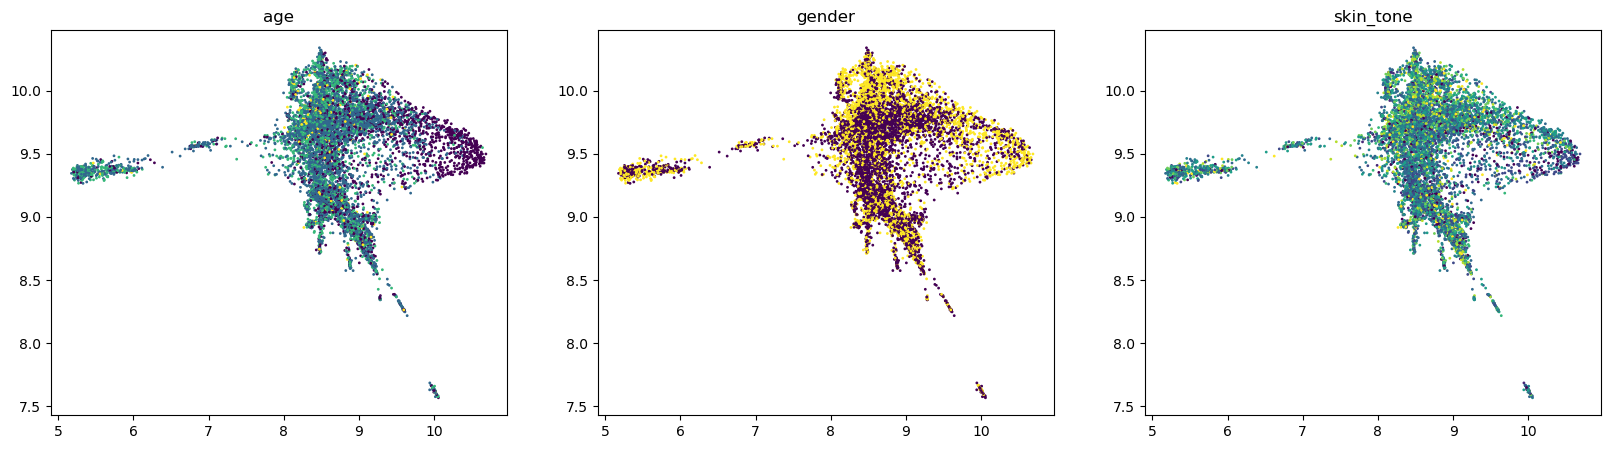

In [59]:
# plot embeddings colored by CATS
fig, axs = plt.subplots(1, len(CATS), figsize=(20, 5))
for i, cat in enumerate(CATS):
    axs[i].scatter(nona_embs[:, 0], nona_embs[:, 1], c=nona_labels[cat], s=1)
    axs[i].set_title(cat)
plt.show()


In [71]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=1000, min_samples=1, allow_single_cluster=False)

clusterer.fit(embs)

labels["cluster"] = clusterer.labels_

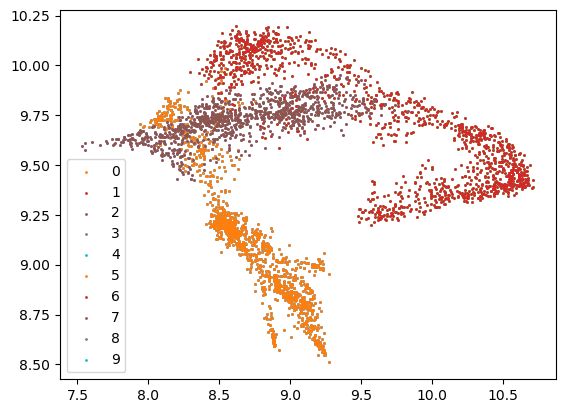

In [77]:
labels["cluster"].value_counts()


In [87]:
noface_idx = labels["cluster"] != 0
noface_labels = labels[noface_idx]
noface_embs = embs[noface_idx]


In [88]:
newclusterer = HDBSCAN(min_cluster_size=100, min_samples=1, allow_single_cluster=False)

newclusterer.fit(noface_embs)

noface_labels["newcluster"] = newclusterer.labels_


C:\Users\jhr\AppData\Local\Temp\ipykernel_11872\1269205636.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noface_labels["newcluster"] = newclusterer.labels_


In [91]:
noface_labels.groupby("newcluster")["skin_tone"].value_counts()

newcluster  skin_tone
-1          monk_4         45
            monk_5         40
            monk_3         37
            monk_2         32
            monk_7         19
            monk_6         11
            monk_1          6
            monk_8          6
            monk_10         4
            monk_9          3
 0          monk_3         77
            monk_4         77
            monk_2         60
            monk_5         56
            monk_7         45
            monk_6         29
            monk_1         18
            monk_8         16
            monk_9         15
            monk_10         2
 1          monk_5         19
            monk_3         16
            monk_4         14
            monk_2         12
            monk_7         10
            monk_6          5
            monk_1          3
            monk_8          3
            monk_9          2
            monk_10         1
 2          monk_3       1380
            monk_4       1265
            monk_5

# Dale! DALL-E
- As a last effort I'll try to generate images using DALL-E
- Afterwards, I'll use KNN to find the closest images to the generated ones

In [3]:
import openai
import json

In [6]:
def read_json(path) -> dict:
    with open(path) as f:
        return json.load(f)

config = read_json("../openai_config.json")
openai.api_key = config["key"]


In [37]:
def query_dalle(prompt, n=1):
  return openai.Image.create(
    prompt=prompt,
    n=n,
    size="256x256"
  )

prompt = "a close-up face photo of a 70 year old, dark-skinned man, photo-realistic, with a smile on his face"


In [39]:
white_prompt = prompt.replace("dark-skinned", "white-skinned").replace("his", "her").replace("man", "woman").replace("70", "24")

white_response = query_dalle(white_prompt, n=5)

In [42]:
white_urls = [img["url"] for img in white_response["data"]]

In [32]:
urls = [url["url"] for url in response["data"]]


TypeError: 'Response' object is not subscriptable

In [23]:
# download images from urls
import requests
import numpy as np
from PIL import Image
from io import BytesIO


In [43]:
def read_img_url(url: str) -> Image.Image:
    response = requests.get(url)
    return Image.open(BytesIO(response.content))
    

imgs = [read_img_url(url) for url in urls]
white_imgs = [read_img_url(url) for url in white_urls]

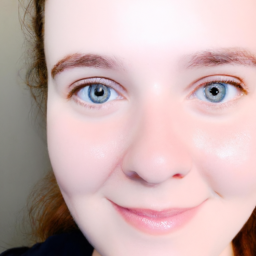

In [35]:
# save images to train folder
from pathlib import Path

img_cat = "dark_65_male"

for i, img in enumerate(imgs):
    img.save(Path(f"../train/{img_cat}_{i}.png"))

In [46]:
white_cat = "white_24_female"
for i, img in enumerate(white_imgs):
    img.save(Path(f"../train/{white_cat}_{i}.png"))

In [83]:
import pickle

url_dict = {img_cat: urls, white_cat: white_urls}

with open("../train/url_dict.pkl", "wb") as f:
    pickle.dump(url_dict, f)


In [65]:
# construct kd-tree from imgs
from sklearn.neighbors import KDTree
from typing import Tuple

def img_to_vec(img: Image.Image, img_size: Tuple[int, int]=(64,64)) -> np.ndarray:
    return np.array(img.resize(img_size).convert("RGB")).reshape(-1)

black_vecs = np.array([img_to_vec(img) for img in imgs])
white_vecs = np.array([img_to_vec(img) for img in white_imgs])
all_imgs = imgs + white_imgs
all_vecs = np.concatenate([black_vecs, white_vecs])

tree = KDTree(all_vecs, leaf_size=2)

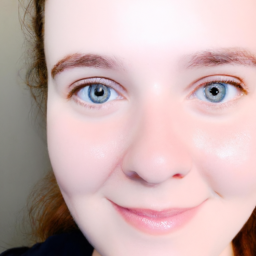

In [80]:
import pandas as pd

def read_img(path: Path, img_size: Tuple[int, int]=(64,64)) -> Image.Image:
    return Image.open(path).resize(img_size).convert("RGB")


labels = pd.read_csv("../train/labels.csv")

# find young white woman
white_test = labels[(labels["real_face"] == 1) & (labels["age"] == "18_30") & (labels["gender"] == "female") & (labels["skin_tone"] == "monk_1")]

white_test_img = read_img(Path("../../Downloads/data_bb1/train/") / white_test["name"].sample(n=1).values[0])

test_vec = img_to_vec(white_test_img)
assert test_vec.shape == all_vecs[0].shape

dist, idx = tree.query(test_vec.reshape(1, -1), k=1)
display(all_imgs[idx[0][0]])